# SCA using deep learning

After collecting, preprocessing and labeling training data, it is time to train the model on that data. Without delving too deep in the concrete NN architecture, basic concept is that the network receives N inputs (where N is length of power traces) and predicts probabilities for 256 classes (for each of the key byte possibilities). It's important to use softmax activation on the last layer in order to allow for accumulating predictions across different traces.
All of this is only for one single key byte which means that 16 models will have to be trained in order to recover the whole key. Nevertheless, in the majority of this project, only single attack byte will be attacked because of computation time saving. Once some reasonably good architecture is found, training will be done on all of the key bytes.

Some of the main advantages over template attacks are as follows: 

* Complete key ranking => even if the attack was unsuccesful, for some bytes, it can be brute forced

# Neural network architectures

A couple of different NN architectures will be tried and tested. Basic multilayer perceptron will be a first choice since it is easy to define and train. As already mentioned, NNs should be able to learn latent features of the data themselves without any human input. Convolutional neural networks proved quite effective in learning discriminating features from images, and that is one of the reasons why CNNs could be used for the problem presented so far. 



### Metrics used for model evaluation

**Key rank** is a commonly used metric in SCA.

## MLP (multi-layered perceptron)

Multilayer perceptron is one of the simplest architectures. It consists of hidden layers which are fully connected. 

Model defined in ASCAD repository will be used as a starting point in developing optimal architecture. Authors of the ASCAD pape reported ..metrics.. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import os
import numpy as np
import h5py
import tensorflow as tf
import keras
from datetime import datetime
import keras_tuner as kt
from tqdm.notebook import tqdm
import tensorflow_addons as tfa

Import utility packages

In [3]:
from utils.data_preparation import SCAML_Dataset
from utils.AES import AES
from utils.training import SCA_Trainer

In [4]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    colab_root_path = '/content/drive/MyDrive/'
    
    training_data_path = colab_root_path + 'datasets/tinyaes/train'
    testing_data_path = colab_root_path + 'datasets/tinyaes/test'
    
    save_models_root_path = colab_root_path + 'models/'
    
    log_root_path = colab_root_path + 'logs/'
else:
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'
    
    save_models_root_path = './models/'
    
    log_root_path = './logs/'

### Load SCAAML dataset

In [5]:
dataset = SCAML_Dataset()

In [6]:
dataset.create_dataset(training_data_path, attack_point='sub_bytes_out', trace_length=20000)
dataset.create_dataset(testing_data_path, attack_point='sub_bytes_out', attack=True, trace_length=20000)

256it [00:01, 154.17it/s]
Loading shards: 100%|█| 256/256 [00:49<00:00,  5.22it
256it [00:01, 140.37it/s]
Loading shards: 100%|█| 256/256 [00:49<00:00,  5.16it


In [10]:
training_data = dataset.get_profiling_dataset(attack_byte=0)

#NOTE: attack data is not needed except when attacking
# attack_data = dataset.get_attack_dataset(attack_byte=0)

In [11]:
training_data.X.shape
training_data.y.shape

TensorShape([65536, 256])

In [75]:
(X_profiling, y_profiling) = training_data.X, training_data.y

#NOTE: attack data is not needed except when attacking
# (X_attack, y_attack, keys, plaintexts) = attack_data.X, attack_data.y, attack_data.keys, attack_data.plaintexts

In [ ]:
input_vector_shape = X_profiling.shape[1]

In [77]:
X_profiling.shape, y_profiling.shape

(TensorShape([65536, 20000, 1]), TensorShape([65536, 256]))

### Create and train vanilla MLP

After loading the data, basic multi layer perceptron is trained. The architecture is based on the architecture described in [ASCAD paper](https://eprint.iacr.org/2018/053.pdf).

In [150]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP = keras.Model(inputs=inputs, outputs=outputs, name='MLP_base_SCAAML')

MLP.summary()

Model: "MLP_base_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               3000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_5 (Dense)      (None, 200)               40200     
                                                                 
 output_layer (Dense)        (None, 256)           

In [98]:
#TODO: create before writing
# model_img_path = './images/' + MLP.name
# tf.keras.utils.plot_model(MLP, show_shapes=True, to_file=model_img_path)

In [151]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

Similar function is defined in utils.training (SCAML_Trainer.train_model), but this one is kept as an example of internal steps of that function. In the rest of this notebook, function from utils package will be used.

In [ ]:
_time = datetime.now().strftime("%Y-%d-%m_%H-%M")

_log_dir = log_root_path + 'MLP_' + _time

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
]

history = MLP.fit(X_profiling, y_profiling, batch_size=32, epochs=50, verbose=1, validation_data=(X_attack, y_attack), callbacks=callbacks_list)

MLP.save(save_models_root_path + MLP.name + _time)

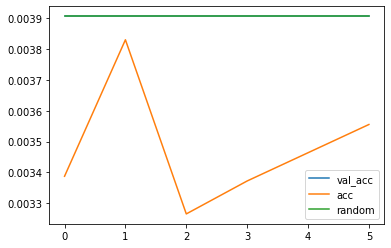

In [153]:
random_accuracy = [1/256] * len(history.history['val_accuracy'])

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(random_accuracy)
plt.legend(['val_acc', 'acc', 'random'],loc='best')
plt.show()

Training was stopped after 5 epochs because validation loss didn't decrease for two consecutive eopchs (EarlyStopping callback).
This model performed really bad, it's even worse than random baseline (1/256 ~0.0039). The accuracy itself doesn't need to be perfect, but it has to be better than random. The reason this model behaved this poorly is probably the huge resolution of input traces (which is much larger than in ASCAD paper).

### Batch normalization

#TODO: theory

Complexity of the input data could be reduced using batch normalization:

In [11]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP_batchnorm = keras.Model(inputs=inputs, outputs=outputs, name='MLP_batch_norm_SCAAML')

MLP_batchnorm.summary()

Model: "MLP_batch_norm_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               3000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                             

In [12]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_batchnorm.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [13]:
_time = datetime.now().strftime("%Y-%d-%m_%H-%M")

_log_dir = log_root_path + 'MLP_batchnorm_' + _time

checkpoint_filepath = './checkpoints/' + MLP_batchnorm.name + '_' + _time

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)
]

history = MLP_batchnorm.fit(X_profiling, y_profiling, batch_size=32, epochs=50, verbose=1, validation_split=0.2, callbacks=callbacks_list)

MLP_batchnorm.save(save_models_root_path + MLP_batchnorm.name + _time)

Epoch 1/50
1639/1639 [==============================] - 37s 22ms/step - loss: 5.6260 - accuracy: 0.0044 - val_loss: 6.3199 - val_accuracy: 0.0044
Epoch 2/50
1639/1639 [==============================] - 39s 24ms/step - loss: 5.5728 - accuracy: 0.0040 - val_loss: 7.1441 - val_accuracy: 0.0036
Epoch 3/50
1639/1639 [==============================] - 50s 30ms/step - loss: 5.5552 - accuracy: 0.0045 - val_loss: 5.8933 - val_accuracy: 0.0051
Epoch 4/50
1639/1639 [==============================] - 37s 23ms/step - loss: 5.2684 - accuracy: 0.0114 - val_loss: 5.9981 - val_accuracy: 0.0123
Epoch 5/50
1639/1639 [==============================] - 37s 23ms/step - loss: 4.5467 - accuracy: 0.0359 - val_loss: 4.4071 - val_accuracy: 0.0327
Epoch 6/50
1639/1639 [==============================] - 37s 23ms/step - loss: 3.8589 - accuracy: 0.0736 - val_loss: 7.2058 - val_accuracy: 0.0111
Epoch 7/50
1639/1639 [==============================] - 36s 22ms/step - loss: 3.4942 - accuracy: 0.1035 - val_loss: 4.1451 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
MLP_batchnorm.save(save_models_root_path + MLP_batchnorm.name + _time)

INFO:tensorflow:Assets written to: ./models/MLP_batch_norm_SCAAML2022-24-08_15-22\assets


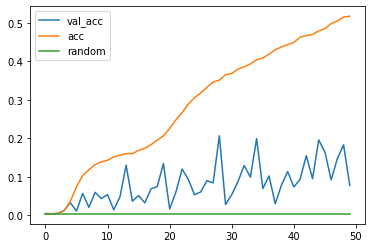

In [14]:
MLP_batchnorm.plot_model_history()

The model is making good predictions on training set, but validation accuracy is fluctuating a lot. This could mean that the model overfitted training data, and that some regularization should take place during training. It makes sense to try and evaluate this model's performance since both training and validation accuracies are better than random. Both precision *and* number of traces impact model's ability to extract secrets in the end.

### Evaluate the model

The model is evaluated on the attack traces and a single byte. Since attack dataset consists of 256 'shards' each containing 256 traces, shuffling is not allowed, and each shard represents a different key. 

#### Define evaluation helper functions
Following functions will be defined in the utils.training as well.

In [106]:
def get_key_probabilities(predictions, plaintexts, attack_byte):
    """! Calculate probabilities for each key guess based on the NN outputs
    @predictions NN predicted values for intermediate values
    @plaintexts Matrix of plaintexts
    @attack_byte Index of the byte to attack
    """

    aes = AES()
    xs = predictions.shape[0]
    
    #                                 num_classes = 256 for key bytes
    key_probabilities = np.zeros((xs, 256))
    for i, predictions_test in enumerate(predictions):
        pt_test = plaintexts[attack_byte][i]
        for j, prediction_value in enumerate(predictions_test):
            sbox_inverse = aes.reverse_SBOX(j)
            predicted_key = sbox_inverse ^ pt_test
            key_probabilities[i][predicted_key] = prediction_value
    
    return np.array(key_probabilities)

In [107]:
def plot_confusion_matrix():
    """! Plot confusion matrix of the evaluated model
    """
    conf_pred = np.asarray(y_predicted_list).flatten()
    conf_true = np.asarray(y_true_list).flatten()
    conf_mat = tf.math.confusion_matrix(conf_pred, conf_true)

    plt.imshow(conf_mat, interpolation='none', cmap='magma')
    plt.colorbar()
    plt.title('Confusion matrix')
    plt.xlabel('Predicted attack points')
    plt.ylabel('True attack points')
    plt.grid(True)

def plot_key_ranks(ranks, num_traces=None):

    plt.figure(figsize=(10, 20))

    for r in ranks:
        plt.plot(r)

    x_max = len(ranks[0]) if num_traces is None else num_traces
    x_labels = [str(x) for x in range(x_max)]
    plt.xticks(np.arange(x_max), labels=x_labels)

    y_max = np.max(np.asarray(ranks))
    y_labels = [str(y) for y in range(y_max)]
    plt.yticks(np.arange(y_max), labels=y_labels, rotation='horizontal')

    plt.ylabel('Key rank')
    plt.xlabel('Number of traces')
    plt.draw()
    plt.pause(0.0001)
    plt.clf()

In [108]:
def evaluate_model(model, dataset, attack_byte, traces_per_chunk=256, keys_to_attack=256, verbose=1):
        """! Evaluate model quality based on SCA relevant metrics.
        This is equivalent to attacking single key byte and displaying the results.
        
        @keys Matrix of keys () s
        @plaintexts Matrix of plaintexts
        @key_byte Key byte index to attack (0, 255)
        @param keys_per_chunk Number of traces in each attack chunk. All the data in one attack chunk is regarding the same key.
        """

        # reset calculated metrics for each new attack
        key_ranks = []
        y_predicted_list = []
        y_true_list = []
        stats_per_trace = {}

        for key_index in tqdm(range(keys_to_attack)):
            attack_dataset = dataset.get_dataset(key_index, attack_byte, num_traces=traces_per_chunk, training=False)
            X_attack, y_attack, keys, plaintexts = attack_dataset.X, attack_dataset.y, attack_dataset.keys, attack_dataset.plaintexts

            true_key_byte = keys[0][0]
            # print(f"True key byte: {true_key_byte}")

            predictions = model.predict(X_attack, verbose=verbose)

            # Intermediate value classes accuracy
            predicted_y_categorical = np.argmax(predictions, axis=1)
            true_y_categorical = np.argmax(y_attack, axis=1)

            y_predicted_list.append(predicted_y_categorical)
            y_true_list.append(true_y_categorical)
            
            key_predicted_probabilities = get_key_probabilities(predictions, plaintexts, attack_byte)

            # Accumulate key predictions and classify
            print(f"Attacking key {key_index}")
            probs = np.zeros(256)
            ranks = []
            for i, p in enumerate(key_predicted_probabilities):
                probs += p
                rankings = np.argsort(probs)[::-1]
                true_key_byte_rank = np.where(rankings == true_key_byte)[0][0]

                ranks.append(true_key_byte_rank)

            key_ranks.append(ranks)

        # num_traces -> (correctPreds_no, % of keys guessed)
        for num_traces in range(traces_per_chunk):
            # Correct key predictions for num_traces
            _ranks_col = np.asarray(key_ranks)[:, num_traces]
            _num_correct = np.sum(_ranks_col == 0, axis=0)
            stats_per_trace[num_traces] = (_num_correct, (_num_correct/keys_to_attack)*100)

        plot_key_ranks(key_ranks)
        plot_confusion_matrix()

In [ ]:
key_ranks = []
y_predicted_list = []
y_true_list = []
stats_per_trace = {}

dataset_batchnorm = dataset

batchNormTrainer = SCA_Trainer()
batchNormTrainer.evaluate_model(MLP_batchnorm, dataset=dataset_batchnorm, attack_byte=0, traces_per_chunk=256, keys_to_attack=20, verbose=1)

In [19]:
batchNormTrainer.evaluation_summary()

0.074798583984375


### Regularization

Since it seems that models are overfitting training data, couple of regularization techniques will be tested. 

#### Dropout

In [81]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1',
                       units=200,
                       activation='relu')(inputs)

# Dropout layer 1
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2',
                       units=200,
                       activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3',
                       units=200,
                       activation='relu')(x)

# Dropout layer 2
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4',
                       units=200,
                       activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5',
                       units=200,
                       activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer',
                             units=256,
                             activation='softmax')(x)

MLP_dropout = keras.Model(inputs=inputs,
                            outputs=outputs,
                            name='MLP_Dropout')

MLP_dropout.summary()

Model: "MLP_batch_norm_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               4000200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 batch_normalization_3 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                             

In [83]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_dropout.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [ ]:
dropout_trainer = SCA_Trainer()

#model, dataset, attack_byte, batch_size, epochs, validation_split, callbacks_list=None, tag='', save_dir=''
dropout_trainer.train_model(MLP_dropout, dataset, ATTACK_BYTE, batch_size=32, epochs=50, validation_split=0.2, tag='rate=0.2')

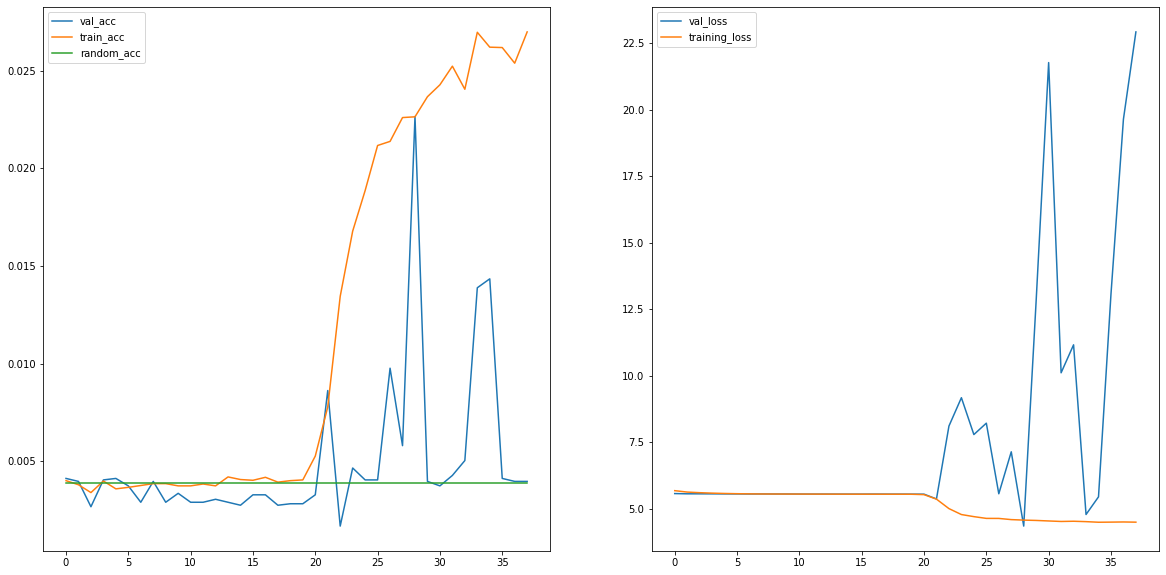

In [90]:
dropout_trainer.plot_model_history()

The model failed to learn anything and training was interrupted because of loss stagnation. The reason could be that there is not enough neurons in hidden layers and with the dropout applied, it performs even worse. Since the validation accuracy is pretty close to random, model probably won't be able to guess anything.

  0%|          | 0/256 [00:00<?, ?it/s]

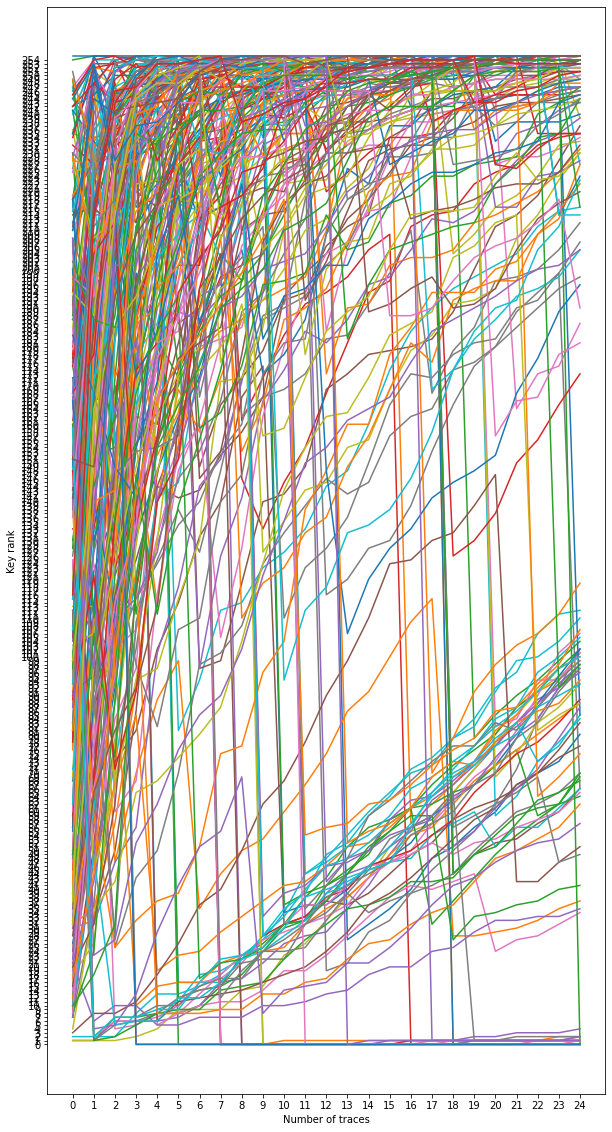

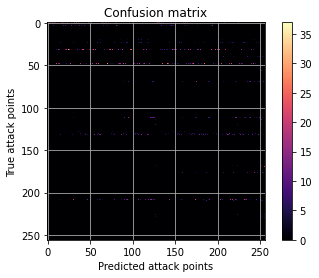

In [94]:
dropout_trainer.evaluate_model(MLP_dropout, dataset, attack_byte=ATTACK_BYTE, traces_per_chunk=25, verbose=0)

From the confusion matrix, it's obvious that model is predicting completely randomly, and the plot of key ranks is pretty bad.

Model will be expanded to contain more neurons in each layer.

In [101]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1',
                       units=5000,
                       activation='relu')(inputs)

# Dropout layer 1
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2',
                       units=2500,
                       activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3',
                       units=2000,
                       activation='relu')(x)

# Dropout layer 2
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4',
                       units=1000,
                       activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5',
                       units=500,
                       activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer',
                             units=256,
                             activation='softmax')(x)

MLP_dropout_v2 = keras.Model(inputs=inputs,
                            outputs=outputs,
                            name='MLP_Dropout_v2')

MLP_dropout_v2.summary()

Model: "MLP_Dropout_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 5000)              100005000 
                                                                 
 dropout_2 (Dropout)         (None, 5000)              0         
                                                                 
 hidden_layer_2 (Dense)      (None, 2500)              12502500  
                                                                 
 batch_normalization_5 (Batc  (None, 2500)             10000     
 hNormalization)                                                 
                                                                 
 hidden_layer_3 (Dense)      (None, 2000)              5002000   
                                                    

In [102]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_dropout_v2.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [103]:
dropout_trainer_v2 = SCA_Trainer()

dropout_trainer_v2.train_model(MLP_dropout, dataset, ATTACK_BYTE, batch_size=32, epochs=50, validation_split=0.2, tag='rate=0.2_moreNeurons')

Training:   0%|                                                                                0/50 ETA: ?s,  …

Epoch 1/50


0/1639                                                                                                       E…

Epoch 2/50


0/1639                                                                                                       E…

Epoch 3/50


0/1639                                                                                                       E…

Epoch 4/50


0/1639                                                                                                       E…

Epoch 5/50


0/1639                                                                                                       E…

Epoch 6/50


0/1639                                                                                                       E…

Epoch 7/50


0/1639                                                                                                       E…

Epoch 8/50


0/1639                                                                                                       E…

Epoch 9/50


0/1639                                                                                                       E…

Epoch 10/50


0/1639                                                                                                       E…

Epoch 11/50


0/1639                                                                                                       E…

Epoch 12/50


0/1639                                                                                                       E…

Epoch 13/50


0/1639                                                                                                       E…

Epoch 14/50


0/1639                                                                                                       E…

Epoch 15/50


0/1639                                                                                                       E…

Epoch 16/50


0/1639                                                                                                       E…

Epoch 17/50


0/1639                                                                                                       E…

Epoch 18/50


0/1639                                                                                                       E…

Epoch 19/50


0/1639                                                                                                       E…

Epoch 20/50


0/1639                                                                                                       E…

Epoch 21/50


0/1639                                                                                                       E…

Epoch 22/50


0/1639                                                                                                       E…

Epoch 23/50


0/1639                                                                                                       E…

Epoch 24/50


0/1639                                                                                                       E…

Epoch 25/50


0/1639                                                                                                       E…

Epoch 26/50


0/1639                                                                                                       E…

Epoch 27/50


0/1639                                                                                                       E…

Epoch 28/50


0/1639                                                                                                       E…

Epoch 29/50


0/1639                                                                                                       E…

Epoch 30/50


0/1639                                                                                                       E…

INFO:tensorflow:Assets written to: ./models/MLP_batch_norm_SCAAMLrate=0.2_moreNeurons\assets


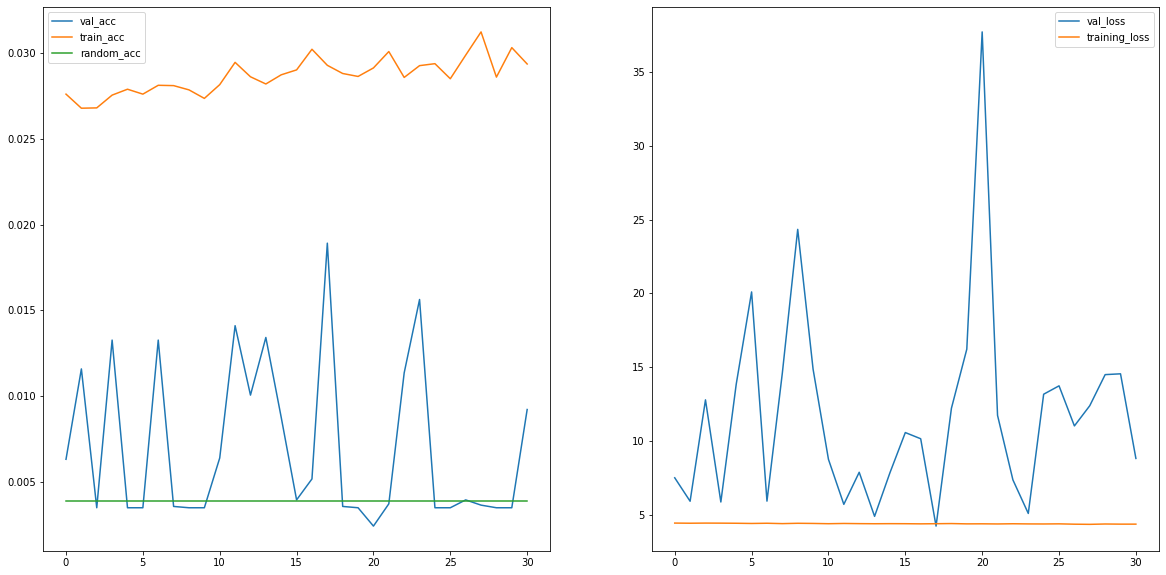

In [105]:
dropout_trainer_v2.plot_model_history()

Adding dropout doesn't help the network accuracy, and even makes it worse apparently. Large number of input points and the fact that dropout shuts down some of the neurons could be the reason for this.

#### L1 and L2 regularization

Try to use L1 and L2 regularizations with no dropouts to see if the network generalizes better.

In [112]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP_regularization = keras.Model(inputs=inputs, outputs=outputs, name='MLP_regularization')

MLP_regularization.summary()

Model: "MLP_regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               4000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 batch_normalization_9 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                                

In [116]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_regularization.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

reg_trainer = SCA_Trainer()

In [117]:
reg_trainer.train_model(MLP_regularization, dataset, ATTACK_BYTE, batch_size=32, epochs=50, validation_split=0.2, verbose=0)

Training:   0%|                                                                                0/50 ETA: ?s,  …

Epoch 1/50


0/1639                                                                                                       E…

Epoch 2/50


0/1639                                                                                                       E…

Epoch 3/50


0/1639                                                                                                       E…

Epoch 4/50


0/1639                                                                                                       E…

Epoch 5/50


0/1639                                                                                                       E…

Epoch 6/50


0/1639                                                                                                       E…

Epoch 7/50


0/1639                                                                                                       E…

Epoch 8/50


0/1639                                                                                                       E…

Epoch 9/50


0/1639                                                                                                       E…

Epoch 10/50


0/1639                                                                                                       E…

Epoch 11/50


0/1639                                                                                                       E…

Epoch 12/50


0/1639                                                                                                       E…

Epoch 13/50


0/1639                                                                                                       E…

Epoch 14/50


0/1639                                                                                                       E…

Epoch 15/50


0/1639                                                                                                       E…

Epoch 16/50


0/1639                                                                                                       E…

Epoch 17/50


0/1639                                                                                                       E…

Epoch 18/50


0/1639                                                                                                       E…

Epoch 19/50


0/1639                                                                                                       E…

Epoch 20/50


0/1639                                                                                                       E…

Epoch 21/50


0/1639                                                                                                       E…

Epoch 22/50


0/1639                                                                                                       E…

Epoch 23/50


0/1639                                                                                                       E…

Epoch 24/50


0/1639                                                                                                       E…

Epoch 25/50


0/1639                                                                                                       E…

Epoch 26/50


0/1639                                                                                                       E…

Epoch 27/50


0/1639                                                                                                       E…

Epoch 28/50


0/1639                                                                                                       E…

Epoch 29/50


0/1639                                                                                                       E…

Epoch 30/50


0/1639                                                                                                       E…

Epoch 31/50


0/1639                                                                                                       E…

Epoch 32/50


0/1639                                                                                                       E…

Epoch 33/50


0/1639                                                                                                       E…

Epoch 34/50


0/1639                                                                                                       E…

Epoch 35/50


0/1639                                                                                                       E…

Epoch 36/50


0/1639                                                                                                       E…

Epoch 37/50


0/1639                                                                                                       E…

Epoch 38/50


0/1639                                                                                                       E…

Epoch 39/50


0/1639                                                                                                       E…

Epoch 40/50


0/1639                                                                                                       E…

Epoch 41/50


0/1639                                                                                                       E…

Epoch 42/50


0/1639                                                                                                       E…

Epoch 43/50


0/1639                                                                                                       E…

Epoch 44/50


0/1639                                                                                                       E…

Epoch 45/50


0/1639                                                                                                       E…

Epoch 46/50


0/1639                                                                                                       E…

Epoch 47/50


0/1639                                                                                                       E…

Epoch 48/50


0/1639                                                                                                       E…

Epoch 49/50


0/1639                                                                                                       E…

Epoch 50/50


0/1639                                                                                                       E…

INFO:tensorflow:Assets written to: ./models/MLP_regularization\assets


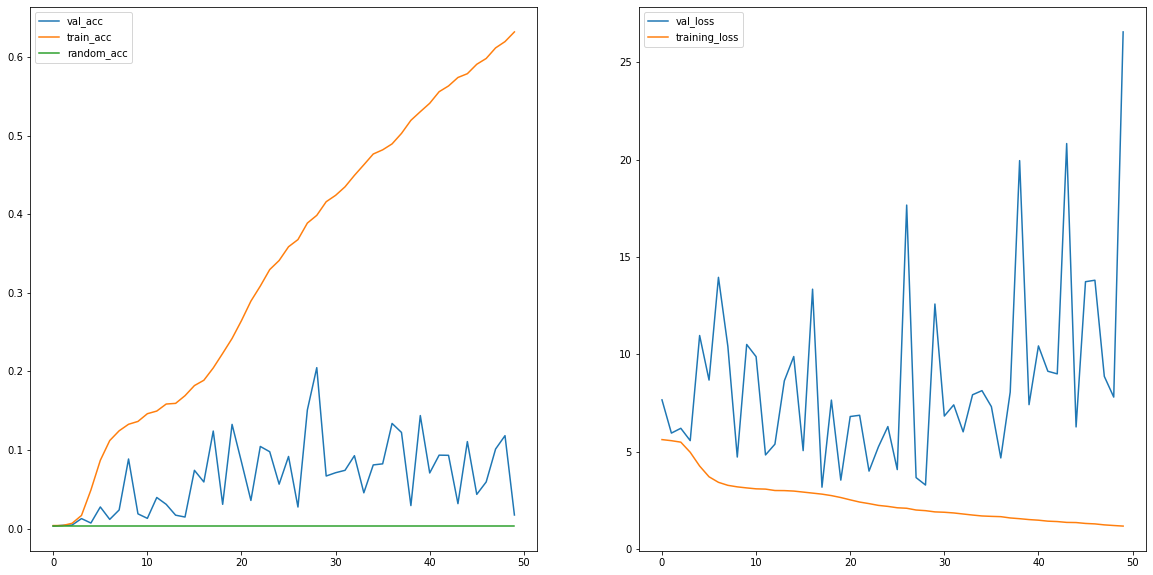

In [118]:
reg_trainer.plot_model_history()

Even though training accuracy is constantly rising, validation accuracy is fluctuating around random baseline. Nevertheless, it can still be evaluated on the attack dataset.

  0%|          | 0/10 [00:00<?, ?it/s]

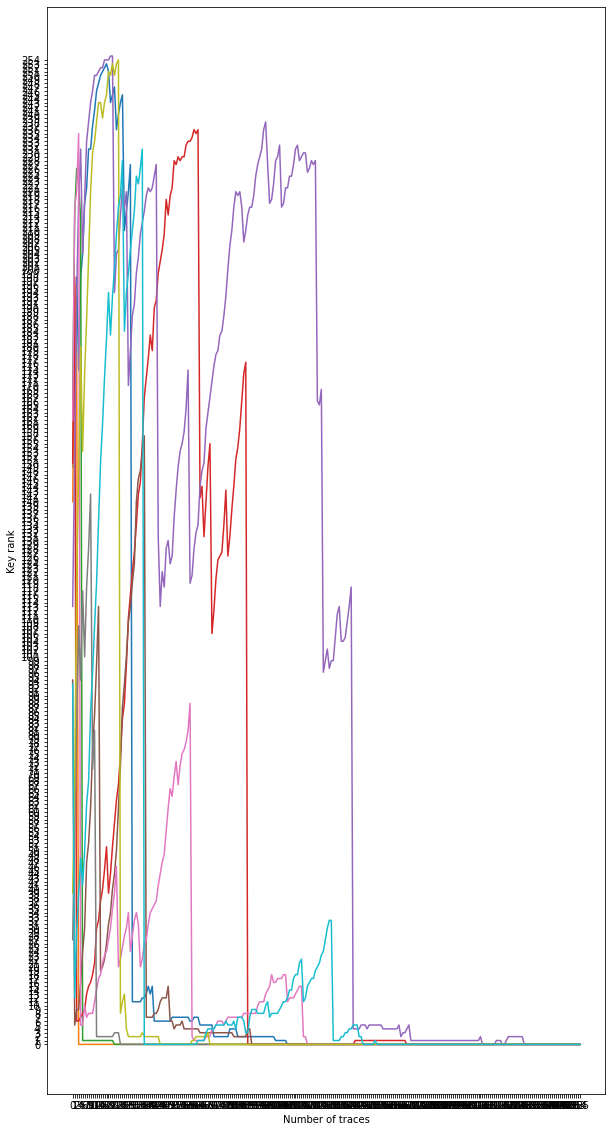

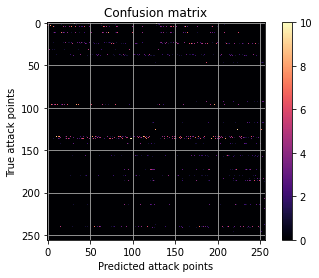

In [138]:
dropout_trainer.evaluate_model(MLP_dropout, dataset, attack_byte=ATTACK_BYTE, traces_per_chunk=256, verbose=0, keys_to_attack=10)

Even though there is no discernable diagonal of the confusion matrix (which would be the case if the model was more accurate), this model was able to crack all of the key bytes with enough traces. More accurate models would be able to do this using less traces.

Maximum accuracy of 100.0 achieved with 206 traces


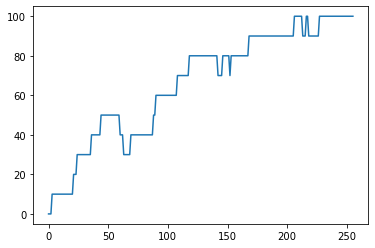

In [141]:
dropout_trainer.evaluation_summary()

Model was able to correctly guess all of the keys using 206 traces per key and that shows accuracy is not the main metric here.

This being said, the goal is to achieve 100% guess accuracy using less traces.

### Data preprocessing

Maybe the input data is too complex for MLP to learn, so some form of data preprocessing will be applied.

## Hypertuning

The results of ad-hoc model constructions are okay, but in order to achieve greater accuracy and key recovery, optimal hyperparameters should be used. Instead of guessing how each hyperparameter can affect the attack success, hyper tuning using Keras tuner will be applied.


[Keras tuner](https://keras.io/api/keras_tuner/)
[Kares tuner quick intro](https://www.youtube.com/watch?v=O85gh3OzluI)

Two types of Keras tuner classes will be used:

* Random search
* Hyperband

Search results and logs are saved in `hyperparam_tuning` folder.

In [32]:
min_layers = 4
max_layers = 10

min_units = 50
max_units = 1000

# Meta model builder
def build_model(hp):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = hp.Int('num_layers', min_value=min_layers, max_value=max_layers)
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = hp.Int('units', min_value=min_units, max_value=max_units, step=50),
                               activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and hp.Boolean('BatchNormalize'):
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 3e-2, 3e-3, 3e-4, 3e-5, 5e-2, 5e-3, 5e-4, 5e-5])

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

#### RandomSearch

In [ ]:
r_tuner = kt.RandomSearch(hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=30,
                    executions_per_trial=1,
                    directory=log_root_path + '/hyperparam_tuning/RandomSearch')

r_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/RandomSearch\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/RandomSearch\untitled_project\tuner0.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [ ]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/RandomSearch'

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

r_tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

Trial 28 Complete [00h 02m 54s]
val_accuracy: 0.00390625

Best val_accuracy So Far: 0.14337158203125
Total elapsed time: 03h 33m 29s

Search: Running Trial #29

Hyperparameter    |Value             |Best Value So Far 
num_layers        |5                 |9                 
units             |200               |750               
BatchNormalize    |True              |True              
learning_rate     |0.0003            |3e-05             

Epoch 1/10
2048/2048 [==============================] - 29s 13ms/step - loss: 5.5526 - accuracy: 0.0039 - recall: 0.0000e+00 - val_loss: 5.5451 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 2/10
2048/2048 [==============================] - 30s 15ms/step - loss: 5.0975 - accuracy: 0.0115 - recall: 4.5776e-05 - val_loss: 4.7397 - val_accuracy: 0.0152 - val_recall: 1.5259e-05
Epoch 3/10
2048/2048 [==============================] - 27s 13ms/step - loss: 4.2902 - accuracy: 0.0288 - recall: 9.4604e-04 - val_loss: 4.5892 - val_accuracy: 0.0219 - 

#### Hyperband

In [30]:
training_data = dataset.get_dataset(attack_byte=0, training=True, trace_length=20000)

In [33]:
training_data.X.shape, training_data.y.shape
input_vector_shape = 20000 #TODO: remove magicnum

In [34]:
h_tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=5,
    directory=log_root_path + '/hyperparam_tuning/Hyperband_v2',
)

h_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [35]:
X_train = training_data.X
y_train = training_data.y

In [41]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/Hyperband' + datetime.now().strftime("%Y-%d-%m_%H-%M")

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

h_tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_split=0.2, 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

Trial 52 Complete [00h 25m 33s]
val_accuracy: 0.10115959495306015

Best val_accuracy So Far: 0.14594140648841858
Total elapsed time: 05h 09m 47s

Search: Running Trial #53

Hyperparameter    |Value             |Best Value So Far 
num_layers        |6                 |6                 
units             |900               |900               
BatchNormalize    |True              |True              
learning_rate     |5e-05             |5e-05             
tuner/epochs      |75                |25                
tuner/initial_e...|25                |9                 
tuner/bracket     |3                 |3                 
tuner/round       |3                 |2                 
tuner/trial_id    |9033a6ae75e776d...|07ed9415c83a542...

Epoch 26/75
1639/1639 [==============================] - 114s 68ms/step - loss: 5.5759 - accuracy: 0.0040 - recall: 0.0000e+00 - val_loss: 5.6084 - val_accuracy: 0.0038 - val_recall: 0.0000e+00
Epoch 27/75
1639/1639 [==============================] - 112s 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1639/1639 [==============================] - 125s 76ms/step - loss: 5.5510 - accuracy: 0.0033 - recall: 0.0000e+00 - val_loss: 5.5463 - val_accuracy: 0.0029 - val_recall: 0.0000e+00
Epoch 2/9
1639/1639 [==============================] - 128s 78ms/step - loss: 5.5461 - accuracy: 0.0036 - recall: 0.0000e+00 - val_loss: 5.5468 - val_accuracy: 0.0031 - val_recall: 0.0000e+00
Epoch 3/9
1639/1639 [==============================] - 127s 78ms/step - loss: 5.5454 - accuracy: 0.0040 - recall: 0.0000e+00 - val_loss: 5.5484 - val_accuracy: 0.0023 - val_recall: 0.0000e+00
Epoch 6/9
1387/1639 [========================>.....] - ETA: 18s - loss: 5.5453 - accuracy: 0.0043 - recall: 0.0000e+00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Construct MLP using best hyperparameters

Hyperband search achieved slightly better validation accuracy (0.146 versus 0.143). After tuning is done, model with best hyperparameters is compiled and trained completely.

In [54]:
best_hyperparams = h_tuner.get_best_hyperparameters()[0]
best_hyperparams.values

{'num_layers': 9,
 'units': 750,
 'BatchNormalize': True,
 'learning_rate': 3e-05,
 'tuner/epochs': 75,
 'tuner/initial_epoch': 25,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '5d8aa389c17eeb4756d9becafad1a8b8'}

In [ ]:
best_MLP = h_tuner.hypermodel.build(best_hyperparams)
best_MLP.save(save_models_root_path + 'BestMLP_Hyperband' + datetime.now().strftime("%Y-%d-%m_%H-%M"))

Visualize best model architecture:

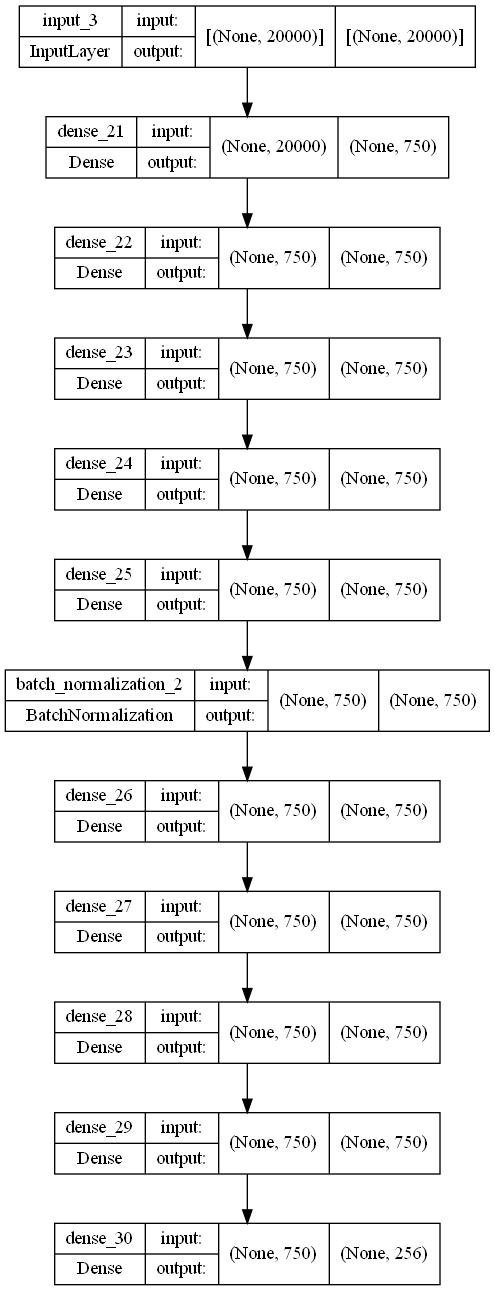

In [56]:
tf.keras.utils.plot_model(best_MLP, show_shapes=True)

Hypertuning progress can be interactively visualized using Tensorboard:

In [79]:
%load_ext tensorboard
%tensorboard --logdir ./logs/hyperparam_tuning/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Run full training on best MLP

In [17]:
best_MLP = tf.keras.models.load_model(save_models_root_path + 'BestMLP_Hyperband2022-27-08_12-01')

In [20]:
ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

trainer = SCA_Trainer()

trainer.train_model(best_MLP, dataset, attack_byte=ATTACK_BYTE, batch_size=32, epochs=25, validation_split=0.2, tag='Hypertuner_BestMLP')

Epoch 1/25
1639/1639 [==============================] - 114s 69ms/step - loss: 5.5523 - accuracy: 0.0039 - recall_1: 0.0000e+00 - val_loss: 5.5750 - val_accuracy: 0.0041 - val_recall_1: 0.0000e+00
Epoch 2/25
1639/1639 [==============================] - 110s 67ms/step - loss: 5.5487 - accuracy: 0.0035 - recall_1: 0.0000e+00 - val_loss: 5.5668 - val_accuracy: 0.0040 - val_recall_1: 0.0000e+00
Epoch 3/25
1639/1639 [==============================] - 128s 78ms/step - loss: 5.5470 - accuracy: 0.0042 - recall_1: 0.0000e+00 - val_loss: 5.5592 - val_accuracy: 0.0045 - val_recall_1: 0.0000e+00
Epoch 4/25
1639/1639 [==============================] - 120s 73ms/step - loss: 5.3864 - accuracy: 0.0069 - recall_1: 0.0000e+00 - val_loss: 6.5759 - val_accuracy: 0.0045 - val_recall_1: 0.0000e+00
Epoch 5/25
1639/1639 [==============================] - 112s 68ms/step - loss: 4.5025 - accuracy: 0.0232 - recall_1: 2.2889e-04 - val_loss: 7.4848 - val_accuracy: 0.0066 - val_recall_1: 0.0000e+00
Epoch 6/25
1639

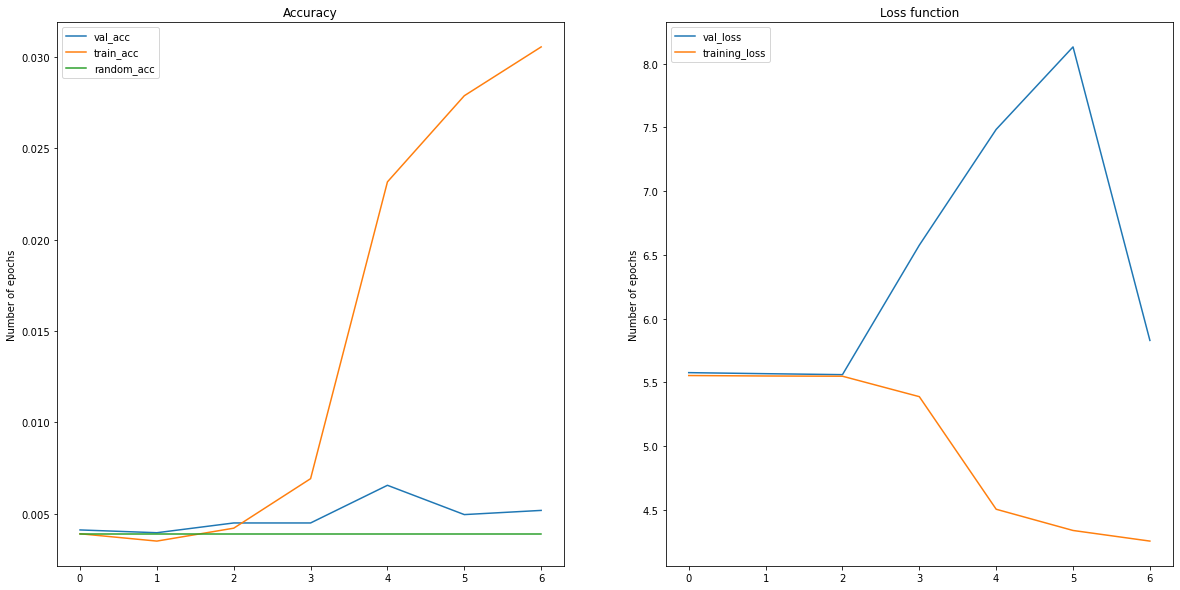

In [22]:
trainer.plot_model_history()

In [23]:
from utils.training import SCA_Trainer

In [24]:
s = SCA_Trainer()

  0%|          | 0/50 [00:00<?, ?it/s]

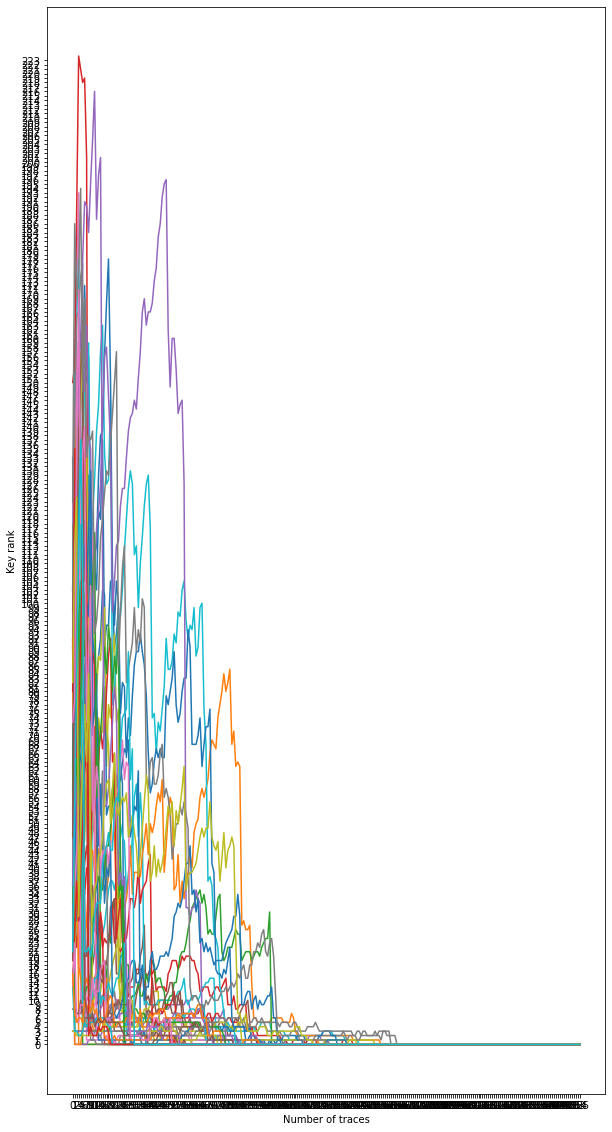

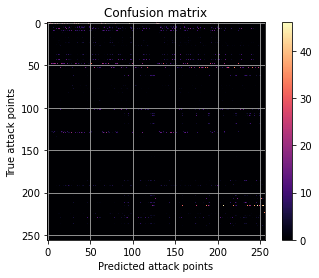

In [26]:
s.evaluate_model(best_MLP,
                 dataset,
                 attack_byte=ATTACK_BYTE,
                 traces_per_chunk=256, # Because of the model's poor accuracy, more traces are needed
                 keys_to_attack=50,
                 verbose=0)

Model achieved average accuracy of 1.2% on 50 different keys (256 traces each)
Maximum key recovery success of 100.0 achieved with 163 traces


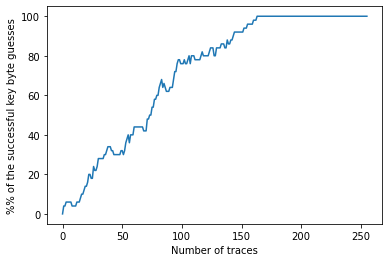

In [29]:
s.evaluation_summary()

Even with horrible classification accuracy, model was able to crack all of the keys with 163 traces.

# Compare best MLP with SCAAML pretrained CNN

Evaluate models on the first key byte.

In [7]:
ATTACK_BYTE = 0

### Evaluate pretrained SCAAML model

In [8]:
scaaml_model_path = "./models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000"
scaaml_pretrained = tf.keras.models.load_model(scaaml_model_path)

OSError: No file or directory found at ./models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000

In [13]:
scaaml_pretrained_trainer = SCA_Trainer()

  0%|          | 0/50 [00:00<?, ?it/s]

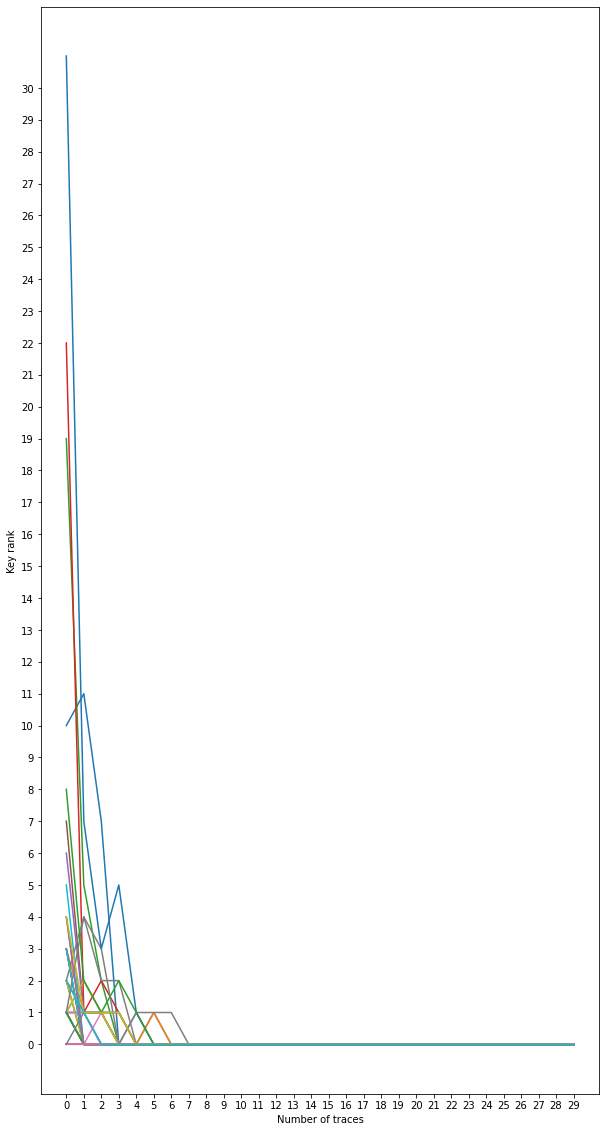

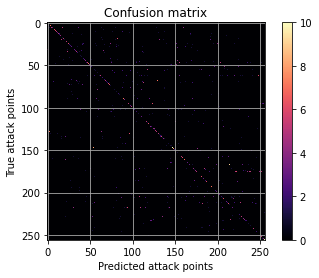

In [16]:
scaaml_pretrained_trainer.evaluate_model(scaaml_pretrained,
                 dataset,
                 attack_byte=ATTACK_BYTE,
                 traces_per_chunk = 30,
                 keys_to_attack=50,
                 verbose=0)

Model achieved average accuracy of 9.22% on 50 different keys (30 traces each)
Maximum key recovery success of 100.0 achieved with 7 traces


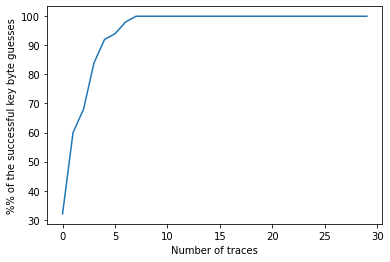

In [17]:
scaaml_pretrained_trainer.evaluation_summary()

### Evaluate best MLP

In [9]:
MLP_best = tf.keras.models.load_model(save_models_root_path + 'model_2Hypertuner_BestMLP')

In [10]:
MLP_best_trainer = SCA_Trainer()

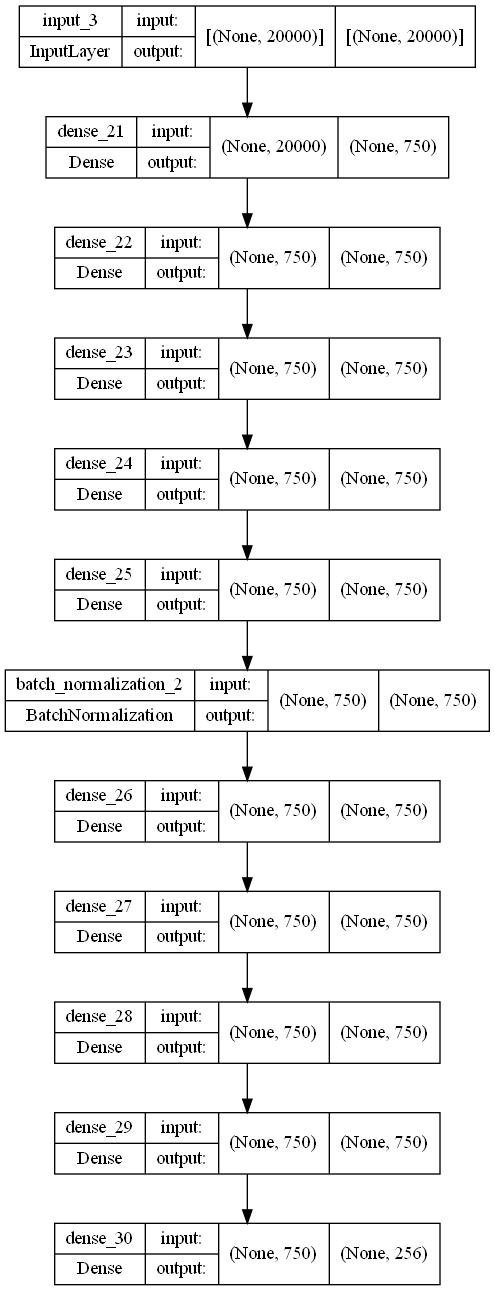

In [13]:
tf.keras.utils.plot_model(MLP_best, show_shapes=True)

In [28]:
MLP_best_trainer.evaluate_model(MLP_best,
                 dataset,
                 attack_byte=ATTACK_BYTE,
                 traces_per_chunk = 30,
                 keys_to_attack=50,
                 verbose=0)

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: in user code:

    File "C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "HyperCNN_3_cls_32_fs_10_ks_4_ps_2_fcs_500_units2022-29-08_12-18" is incompatible with the layer: expected shape=(None, 8000, 1), found shape=(None, 20000, 1)


In [ ]:
MLP_best_trainer.evaluation_summary()

## Train MLPs to recover the whole key

In [27]:
best_MLP_architecture = {'num_layers': 9,
                         'units': 750,
                         'BatchNormalize': True,
                         'learning_rate': 3e-05}

In [34]:
input_vector_shape = 20000

In [35]:
h_tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=5,
    directory=log_root_path + '/hyperparam_tuning/RandomSearch',
)

h_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/RandomSearch\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/RandomSearch\untitled_project\tuner0.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [36]:
best_hyperparams = h_tuner.get_best_hyperparameters()[0]
best_hyperparams.values

{'num_layers': 9,
 'units': 750,
 'BatchNormalize': True,
 'learning_rate': 3e-05,
 'tuner/epochs': 75,
 'tuner/initial_epoch': 25,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '5d8aa389c17eeb4756d9becafad1a8b8'}

In [40]:
best_hyperparams_cfg = {'num_layers': 9,
 'units': 750,
 'BatchNormalize': True,
 'learning_rate': 3e-05,}

In [43]:
def build_model_from_config(config):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = config['num_layers']
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = config['units'], activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and config['BatchNormalize']:
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    
    learning_rate = config['learning_rate']

    
    model_name = f'HyperMLP_' \
                 f'{no_layers}_layers_' \
                 f'{str(config["units"])}_units_' + datetime.now().strftime("%Y-%d-%m_%H-%M")
    
    model = keras.Model(name=model_name,
                        inputs=inputs,
                        outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

In [ ]:
full_trainer_list = []
models_list = []

ATTACK_POINT = 'sub_bytes_out'

# Start from 1 because byte 0 model is already trained
for attack_byte in range(1,16):
    m = build_model_from_config(best_hyperparams_cfg)
    
    t = SCA_Trainer()
    t.train_model(m,
                  dataset,
                  attack_byte=attack_byte,
                  batch_size=32,
                  epochs=10,
                  validation_split=0.2,tag=f'FullMLP_byte_{attack_byte}')
    
    models_list.append(m)
    full_trainer_list.append(t)

Epoch 1/10
1639/1639 [==============================] - 128s 77ms/step - loss: 5.5525 - accuracy: 0.0040 - recall: 0.0000e+00 - val_loss: 5.5648 - val_accuracy: 0.0037 - val_recall: 0.0000e+00
Epoch 2/10
1639/1639 [==============================] - 143s 87ms/step - loss: 5.5486 - accuracy: 0.0041 - recall: 0.0000e+00 - val_loss: 5.5593 - val_accuracy: 0.0033 - val_recall: 0.0000e+00
Epoch 3/10
1639/1639 [==============================] - 132s 80ms/step - loss: 5.1019 - accuracy: 0.0110 - recall: 0.0000e+00 - val_loss: 4.3181 - val_accuracy: 0.0236 - val_recall: 0.0000e+00
Epoch 4/10
1639/1639 [==============================] - 133s 81ms/step - loss: 4.3073 - accuracy: 0.0262 - recall: 1.1444e-04 - val_loss: 4.6597 - val_accuracy: 0.0178 - val_recall: 0.0018
Epoch 5/10
1639/1639 [==============================] - 131s 80ms/step - loss: 4.1805 - accuracy: 0.0307 - recall: 0.0011 - val_loss: 9.1046 - val_accuracy: 0.0092 - val_recall: 0.0027
Epoch 6/10
1639/1639 [=========================

1639/1639 [==============================] - 128s 78ms/step - loss: 5.5524 - accuracy: 0.0038 - recall: 0.0000e+00 - val_loss: 5.5676 - val_accuracy: 0.0045 - val_recall: 0.0000e+00
Epoch 2/10
1639/1639 [==============================] - 120s 73ms/step - loss: 5.5491 - accuracy: 0.0038 - recall: 0.0000e+00 - val_loss: 5.5628 - val_accuracy: 0.0034 - val_recall: 0.0000e+00
Epoch 3/10
1639/1639 [==============================] - 115s 70ms/step - loss: 5.1406 - accuracy: 0.0102 - recall: 0.0000e+00 - val_loss: 10.8663 - val_accuracy: 0.0042 - val_recall: 0.0000e+00
Epoch 4/10
1639/1639 [==============================] - 124s 76ms/step - loss: 4.3561 - accuracy: 0.0254 - recall: 1.5259e-04 - val_loss: 4.7524 - val_accuracy: 0.0153 - val_recall: 0.0000e+00
Epoch 5/10
1639/1639 [==============================] - 103s 63ms/step - loss: 4.2069 - accuracy: 0.0307 - recall: 6.4851e-04 - val_loss: 3.9671 - val_accuracy: 0.0362 - val_recall: 0.0000e+00
Epoch 6/10
1639/1639 [=======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1639/1639 [==============================] - 129s 79ms/step - loss: 4.0939 - accuracy: 0.0376 - recall: 0.0030 - val_loss: 13.0686 - val_accuracy: 0.0079 - val_recall: 0.0000e+00
Epoch 10/10
1639/1639 [==============================] - 119s 72ms/step - loss: 3.7155 - accuracy: 0.0753 - recall: 0.0056 - val_loss: 7.1249 - val_accuracy: 0.0313 - val_recall: 0.0111
INFO:tensorflow:Assets written to: ./models/HyperMLP_9_layers_750_units_2022-31-08_00-33FullMLP_byte_11\assets
Epoch 1/10
1639/1639 [==============================] - 154s 93ms/step - loss: 5.5522 - accuracy: 0.0037 - recall: 0.0000e+00 - val_loss: 5.5664 - val_accuracy: 0.0034 - val_recall: 0.0000e+00
Epoch 2/10
1639/1639 [==============================] - 118s 72ms/step - loss: 5.5484 - accuracy: 0.0039 - recall: 0.0000e+00 - val_loss: 5.5663 - val_accuracy: 0.0050 - val_recall: 0.0000e+00
Epoch 3/10
 822/1639 [==============>...............] - ETA: 51s - loss: 5.5473 - accuracy: 0.0042 - recall: 0.0000e+00

---

# Tips:

There is a talk on tuning neural networks for the purpose of Side Channel Analysis: [Tuning NN for SCA](https://www.youtube.com/watch?v=uSpFfacjU4g)

Couple of techniques are listed there:
* Start simple (underfit) or start complex (overfit) and move towards the middle
* Models don't have to have great accuracy => slightly better than random could work with enough traces